
Comparing characters:   4%|▎         | 2853/80601 [02:42<1:13:59, 17.51it/s]

Comparing characters: 100%|██████████| 80601/80601 [01:17<00:00, 1043.61it/s]


All images with similarity >= 0.7 have been saved in similar_characters_output_TH_7.zip. You can now download the ZIP file.


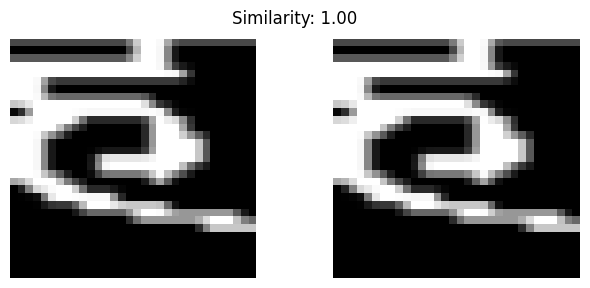

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_ubyte
from skimage.measure import regionprops, label
from skimage.feature import hog
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm  # Progress bar
import os
import zipfile

# Function to perform thinning (skeletonization)
def thin_image(img):
    binary_img = img > 0
    skeleton_img = skeletonize(binary_img)
    return img_as_ubyte(skeleton_img)

# Function to count white pixels in each column and replace columns with single white pixel by 1
def process_thinned_image(thinned_img):
    vertical_hist = np.sum(thinned_img, axis=0)
    single_white_pixel_cols = vertical_hist == 255
    modified_img = np.copy(thinned_img)
    modified_img[:, single_white_pixel_cols] = 255
    return vertical_hist, modified_img

# Function to invert the image and mark bounding boxes
def invert_and_segment_characters(modified_img, min_width=5, min_height=5):
    if modified_img.size == 0:
        raise ValueError("Modified image is empty or not correctly loaded")

    inverted_img = np.where(modified_img == 255, 0, 255).astype(np.uint8)
    labeled_img = label(inverted_img, connectivity=2)
    regions = regionprops(labeled_img)
    bounding_boxes = []
    for region in regions:
        start, left, end, right = int(region.bbox[0]), int(region.bbox[1]), int(region.bbox[2]), int(region.bbox[3])
        width = right - left
        height = end - start
        if width >= min_width and height >= min_height:
            bounding_boxes.append((start, left, end, right))
    return inverted_img, bounding_boxes

# Function to compute HOG descriptor for a character image
def compute_hog_descriptor(char_img):
    resized_char_img = cv2.resize(char_img, (32, 32), interpolation=cv2.INTER_AREA)  # Smaller size for better visualization
    hog_descriptor = hog(resized_char_img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, channel_axis=None)
    return hog_descriptor

# Function to compute similarity between two character HOG descriptors
def compute_similarity(hog1, hog2):
    return cosine_similarity([hog1], [hog2])[0][0]

# Function to segment lines in the image
def segment_lines(binary_image):
    horizontal_hist = np.sum(binary_image, axis=1)
    no_white_rows = horizontal_hist == 0
    inverted_img = np.copy(binary_image)
    inverted_img[no_white_rows] = 0
    inverted_img[~no_white_rows] = 255
    labeled_img = label(inverted_img, connectivity=2)
    regions = regionprops(labeled_img)
    bounding_boxes = [(int(region.bbox[0]), int(region.bbox[1]), int(region.bbox[2]), int(region.bbox[3])) for region in regions]
    return bounding_boxes, inverted_img

# Load the image
img_path = '/kaggle/input/sanskrit-model-train/img (13).jpg'  # Update with the correct path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

# Apply Otsu's thresholding to binarize the image
_, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Apply line segmentation
line_bounding_boxes, _ = segment_lines(binary_img)

# List to store HOG descriptors and corresponding character images for all characters
hog_descriptors = []
character_images = []

# Directory to store the images with similarity >= 0.6
output_dir = 'similar_characters_output'
os.makedirs(output_dir, exist_ok=True)

# Process each line image
if line_bounding_boxes:
    for line_idx, (start, left, end, right) in enumerate(line_bounding_boxes):
        line_img = binary_img[start:end, left:right]
        thinned_img = thin_image(line_img)

        # Process the thinned image to count white pixels and replace columns with single white pixel
        _, modified_img = process_thinned_image(thinned_img)

        # Invert the image and mark bounding boxes for characters (set minimum size for characters)
        inverted_img, bounding_boxes = invert_and_segment_characters(modified_img, min_width=10, min_height=10)

        # Extract HOG descriptors and character images for each character
        for (start, left, end, right) in bounding_boxes:
            char_img = line_img[start:end, left:right]
            hog_descriptor = compute_hog_descriptor(char_img)
            hog_descriptors.append(hog_descriptor)
            character_images.append(char_img)

# Compute pairwise similarities between all characters
num_chars = len(hog_descriptors)

# Set up the figure for plotting
plt.figure(figsize=(6, 6))

# Add a progress bar
pbar = tqdm(total=num_chars * (num_chars - 1) // 2, desc="Comparing characters")

# Store character pairs with similarity >= 0.6
similar_characters = []

# Display each pair of characters and similarity score one by one if similarity >= 0.6
for i in range(num_chars):
    for j in range(i + 1, num_chars):
        similarity_score = compute_similarity(hog_descriptors[i], hog_descriptors[j])

        # Only display pairs with similarity >= 0.7
        if similarity_score >= 0.7:
            # Create a blank space (padding) between the two images for better visibility
            blank_space = np.ones((32, 10)) * 255  # White space of size 32x10 pixels

            # Combine the images with blank space in between
            combined_img = np.hstack([cv2.resize(character_images[i], (32, 32)), blank_space, cv2.resize(character_images[j], (32, 32))])

            # Display the combined image and similarity score
            plt.imshow(combined_img, cmap='gray')
            plt.title(f'Similarity: {similarity_score:.2f}')
            plt.axis('off')
            #plt.pause(0.5)  # Pause for 0.5 seconds to show each comparison

            # Store character pairs with similarity >= 0.6
            similar_characters.append((i, j, similarity_score))
            # Save the image to the output folder
            output_image_path = os.path.join(output_dir, f'char_{i}_and_char_{j}_sim_{similarity_score:.2f}.png')
            plt.imsave(output_image_path, combined_img, cmap='gray')

        # Update the progress bar
        pbar.update(1)

# Close the progress bar
pbar.close()

# Zip the output directory for download
zip_filename = 'similar_characters_output_TH_7.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for root, dirs, files in os.walk(output_dir):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), output_dir))

print(f"All images with similarity >= 0.7 have been saved in {zip_filename}. You can now download the ZIP file.")

plt.tight_layout()
plt.show()
